In [1]:
from d2l import torch as d2l
import torch
from torch import nn
import numpy as np
import math

In [2]:
maxdegree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = torch.zeros(maxdegree)  # Allocate lots of empty space
true_w[0:4] = torch.tensor([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(maxdegree).reshape(1, -1))
gamma = np.vectorize(math.gamma)  # Use math.gamma function for numpy array
poly_features = poly_features / (
    gamma(np.arange(maxdegree) + 1).reshape(1, -1))

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1)

features = torch.from_numpy(features).type(torch.float32)
poly_features = torch.from_numpy(poly_features).type(torch.float32)
labels = torch.from_numpy(labels).type(torch.float32)

In [3]:
features[:2], poly_features[:2], labels[:2]

(tensor([[-0.6729],
         [ 0.2809]]),
 tensor([[ 1.0000e+00, -6.7287e-01,  2.2638e-01, -5.0775e-02,  8.5413e-03,
          -1.1494e-03,  1.2890e-04, -1.2391e-05,  1.0422e-06, -7.7918e-08,
           5.2429e-09, -3.2071e-10,  1.7983e-11, -9.3079e-13,  4.4736e-14,
          -2.0068e-15,  8.4394e-17, -3.3404e-18,  1.2487e-19, -4.4222e-21],
         [ 1.0000e+00,  2.8085e-01,  3.9439e-02,  3.6922e-03,  2.5924e-04,
           1.4562e-05,  6.8161e-07,  2.7347e-08,  9.6007e-10,  2.9960e-11,
           8.4143e-13,  2.1483e-14,  5.0281e-16,  1.0863e-17,  2.1791e-19,
           4.0801e-21,  7.1619e-23,  1.1832e-24,  1.8461e-26,  2.7289e-28]]),
 tensor([3.1996, 5.2846]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # sum_loss, num_examples
    for X, y in data_iter:
        l = loss(net(X), y.reshape(-1, 1))
        if l.nelement() != 1:
            metric.add(l.sum(), y.numpy().size)
        else:
            metric.add(l*len(y), y.numpy().size)
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=1000):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(1, num_epochs+1):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch % 50 == 0:
            animator.add(epoch, (evaluate_loss(net, train_iter, loss),
                                 evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.061031   1.2000059 -3.399989   5.599985 ]]


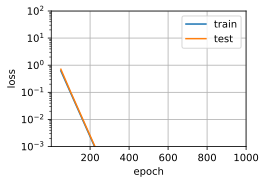

In [6]:
# Pick the first four dimensions, i.e., 1, x, x^2, x^3 from the polynomial
# features
train(poly_features[:n_train, 0:4], poly_features[n_train:, 0:4],
      labels[:n_train].reshape(-1,1), labels[n_train:].reshape(-1,1))

weight: [[ 4.276802   3.5658243 -1.2386043]]


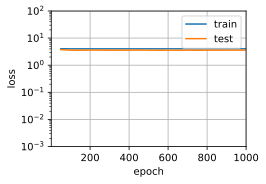

In [7]:
# Pick the first four dimensions, i.e., 1, x from the polynomial features
train(poly_features[:n_train, 0:3], poly_features[n_train:, 0:3],
      labels[:n_train].reshape(-1,1), labels[n_train:].reshape(-1,1))

weight: [[ 5.035503    1.260704   -3.250009    5.232906   -0.5594437   1.2372892
   0.08802988  0.1061677   0.15732187 -0.14660217  0.02442818 -0.06173505
  -0.11211979 -0.19787359 -0.21813326 -0.06980886 -0.12708747 -0.13765527
  -0.15270847  0.2064889 ]]


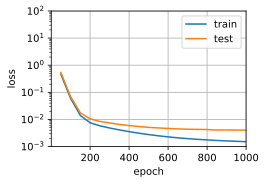

In [8]:
n_subset = 100  # Subset of data to train on
n_degree = 20  # Degree of polynomials
train(poly_features[1:n_subset, 0:n_degree],
      poly_features[n_train:, 0:n_degree], labels[1:n_subset].reshape(-1,1),
      labels[n_train:].reshape(-1,1))